# MEC Competition

## Libraries


In [174]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import radians
import requests
import json
from math import radians, cos, sin, asin, sqrt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

## Training data analysis

In [134]:
df_train = pd.read_csv('training_WeeklyAggregate.csv')
df_train.head(5)

,sourceid,dstid,dow,mean_travel_time
0,10,241,3,2334.43
1,10,612,5,1529.83
2,10,905,4,1390.04
3,10,407,7,157.91
4,10,603,4,1781.67


In [135]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9830 entries, 0 to 9829
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sourceid          9830 non-null   int64  
 1   dstid             9830 non-null   int64  
 2   dow               9830 non-null   int64  
 3   mean_travel_time  9830 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 307.3 KB


<AxesSubplot:xlabel='dow', ylabel='Count'>

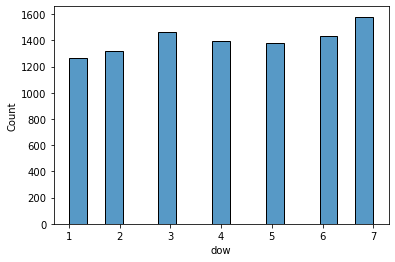

In [136]:
sns.histplot(df_train['dow'])

C:\Users\aliyu\anaconda3\envs\ali_root\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mean_travel_time', ylabel='Density'>

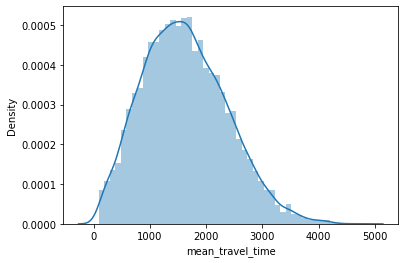

In [137]:
sns.distplot(df_train['mean_travel_time'])

Based on the data it can be said that
1) Sourceid and dstid are unique values.
2) Mean_travel_time is normally distributed
3) Dow column is not numerical but categorical
4) No null values
5) No outliers

## Json data analysis

In [138]:
df_json = gpd.read_file('london.json')
df_json.head(5)

,msoa_code,msoa_name,la_code,la_name,geoeast,geonorth,popeast,popnorth,area_km2,MOVEMENT_ID,DISPLAY_NAME,geometry
0,E02000508,Hillingdon 015,00AS,Hillingdon,506163,183536,505978,183811,2.74660,0,"Hillingdon, 00AS (0)","MULTIPOLYGON (((-0.47794 51.55485, -0.47665 51..."
1,E02000716,Newham 003,00BB,Newham,541978,186009,541870,185568,1.56517,1,"Newham, 00BB (1)","MULTIPOLYGON (((0.05255 51.56171, 0.05310 51.5..."
2,E02000747,Newham 034,00BB,Newham,539578,181317,539891,181438,2.08241,2,"Newham, 00BB (2)","MULTIPOLYGON (((0.01001 51.52181, 0.01003 51.5..."
3,E02000748,Newham 035,00BB,Newham,542500,181152,542439,181339,1.33175,3,"Newham, 00BB (3)","MULTIPOLYGON (((0.05392 51.51611, 0.05174 51.5..."
4,E02000749,Newham 036,00BB,Newham,541047,181103,540847,181294,1.41902,4,"Newham, 00BB (4)","MULTIPOLYGON (((0.03241 51.51704, 0.03179 51.5..."


<AxesSubplot:>

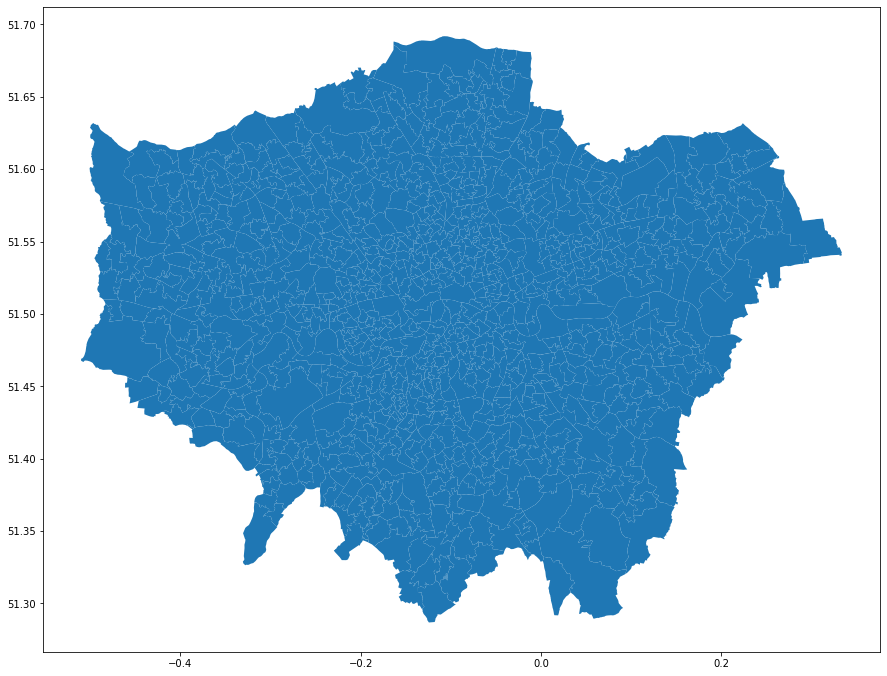

In [139]:
df_json.plot(figsize=(15,15))

<AxesSubplot:>

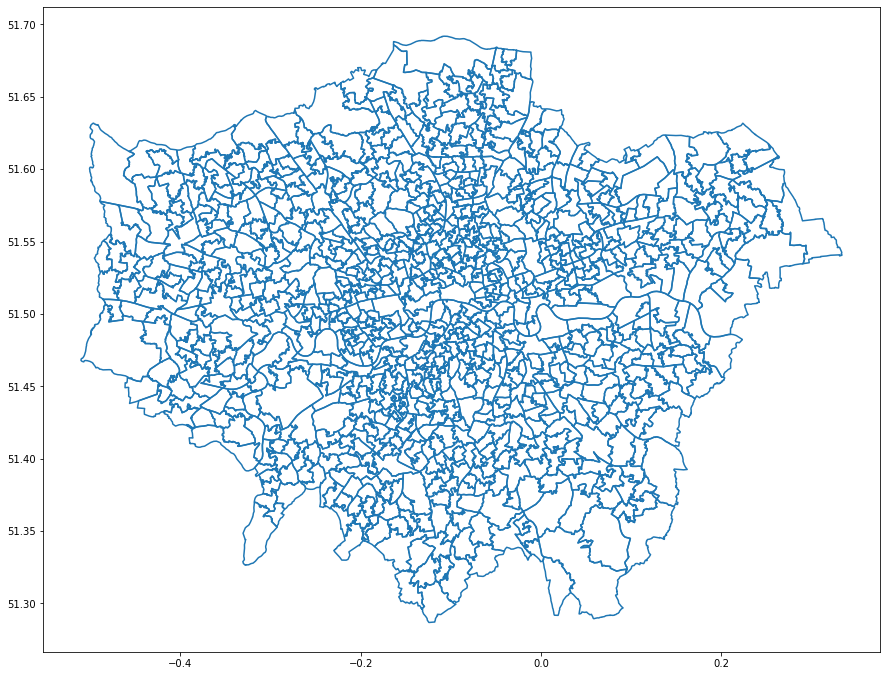

In [140]:
df_json.boundary.plot(figsize=(15,15))

In [141]:
df_json.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   msoa_code     983 non-null    object  
 1   msoa_name     983 non-null    object  
 2   la_code       983 non-null    object  
 3   la_name       983 non-null    object  
 4   geoeast       983 non-null    int64   
 5   geonorth      983 non-null    int64   
 6   popeast       983 non-null    int64   
 7   popnorth      983 non-null    int64   
 8   area_km2      983 non-null    float64 
 9   MOVEMENT_ID   983 non-null    object  
 10  DISPLAY_NAME  983 non-null    object  
 11  geometry      983 non-null    geometry
dtypes: float64(1), geometry(1), int64(4), object(6)
memory usage: 92.3+ KB


First 4 columns are just names and not that helpful to us. Based on that:
 1) Most important columns are the ones starting with geoeast column.
 2) There are no null values.
 3) No outliers as well

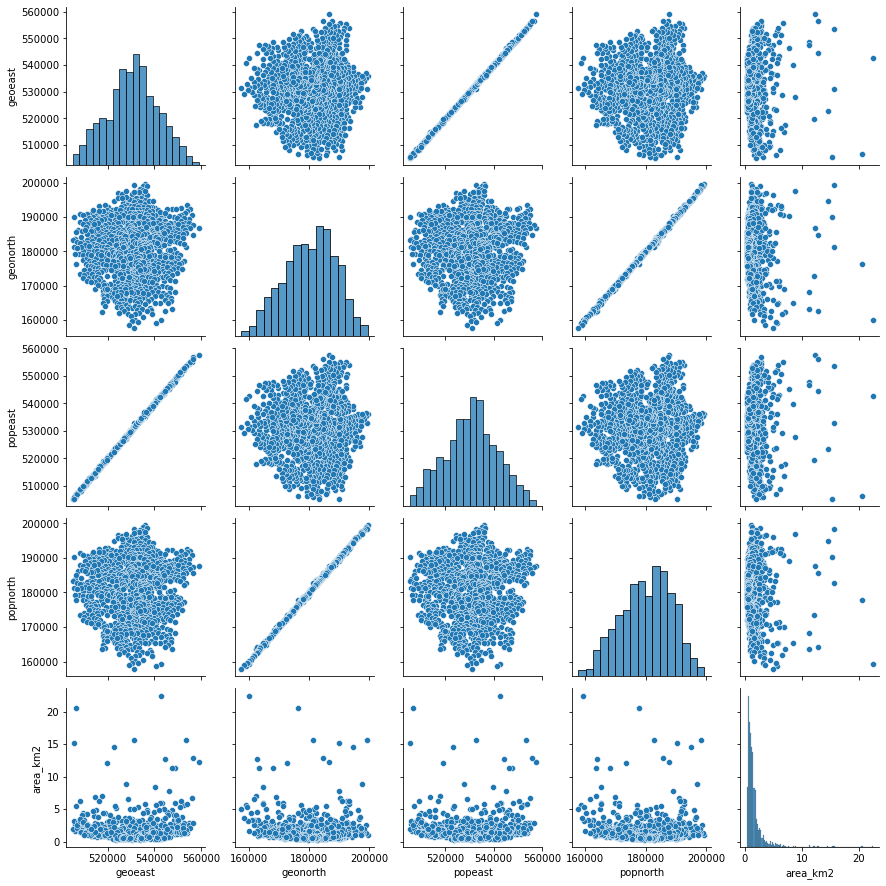

In [142]:
sns.pairplot(df_json)

From here we can observe that:
1) Geoeast, geonorth, popeast, popnorth are normally distributed
2) Geoeast correlates with popeast and geonorth correlates with popnorth columns
3) Area_km2 column has high amount of outliers. This can negatively effect the model later on.

## Making new useful dataset

Based on previous obvervations:
1) Movement ID in df_json has the same identifiers as sourceid and dstid columns as in df_train dataframe.
2) Necessary columns should be taken to 1 dataset and combined
3) Outliers should be removed in new dataset
4) Factors that can affect mean_travel_time should be considered

### Pythagorian Distance

In [143]:
df_json.head(5)

,msoa_code,msoa_name,la_code,la_name,geoeast,geonorth,popeast,popnorth,area_km2,MOVEMENT_ID,DISPLAY_NAME,geometry
0,E02000508,Hillingdon 015,00AS,Hillingdon,506163,183536,505978,183811,2.74660,0,"Hillingdon, 00AS (0)","MULTIPOLYGON (((-0.47794 51.55485, -0.47665 51..."
1,E02000716,Newham 003,00BB,Newham,541978,186009,541870,185568,1.56517,1,"Newham, 00BB (1)","MULTIPOLYGON (((0.05255 51.56171, 0.05310 51.5..."
2,E02000747,Newham 034,00BB,Newham,539578,181317,539891,181438,2.08241,2,"Newham, 00BB (2)","MULTIPOLYGON (((0.01001 51.52181, 0.01003 51.5..."
3,E02000748,Newham 035,00BB,Newham,542500,181152,542439,181339,1.33175,3,"Newham, 00BB (3)","MULTIPOLYGON (((0.05392 51.51611, 0.05174 51.5..."
4,E02000749,Newham 036,00BB,Newham,541047,181103,540847,181294,1.41902,4,"Newham, 00BB (4)","MULTIPOLYGON (((0.03241 51.51704, 0.03179 51.5..."


In [144]:
df_json.drop(['msoa_code', 'msoa_name', 'la_code', 'la_name', 'DISPLAY_NAME'], axis=1, inplace=True)
df_json

,geoeast,geonorth,popeast,popnorth,area_km2,MOVEMENT_ID,geometry
0,506163,183536,505978,183811,2.746600,0,"MULTIPOLYGON (((-0.47794 51.55485, -0.47665 51..."
1,541978,186009,541870,185568,1.565170,1,"MULTIPOLYGON (((0.05255 51.56171, 0.05310 51.5..."
2,539578,181317,539891,181438,2.082410,2,"MULTIPOLYGON (((0.01001 51.52181, 0.01003 51.5..."
3,542500,181152,542439,181339,1.331750,3,"MULTIPOLYGON (((0.05392 51.51611, 0.05174 51.5..."
4,541047,181103,540847,181294,1.419020,4,"MULTIPOLYGON (((0.03241 51.51704, 0.03179 51.5..."
...,...,...,...,...,...,...,...
978,527028,181254,527172,181179,0.689337,978,"MULTIPOLYGON (((-0.17019 51.51994, -0.16019 51..."
979,526396,181129,526375,181042,0.484638,979,"MULTIPOLYGON (((-0.17867 51.52008, -0.17898 51..."
980,529921,178656,529758,178698,0.539208,980,"MULTIPOLYGON (((-0.12279 51.49453, -0.12305 51..."
981,529123,178488,529140,178401,0.363777,981,"MULTIPOLYGON (((-0.14126 51.49455, -0.14080 51..."


In [145]:
df_train = df_train.join(df_json, on='sourceid')
df_train = df_train.rename(columns={'geoeast': 'src_geoeast', 'geonorth': 'src_geonorth', 'popeast': 'src_popeast', 'popnorth': 'src_popnorth', 'area_km2':'src_area'})
df_train.drop(['MOVEMENT_ID','geometry'], inplace=True, axis=1)
df_train

,sourceid,dstid,dow,mean_travel_time,src_geoeast,src_geonorth,src_popeast,src_popnorth,src_area
0,10,241,3,2334.43,542413,182380,542450,182415,0.790802
1,10,612,5,1529.83,542413,182380,542450,182415,0.790802
2,10,905,4,1390.04,542413,182380,542450,182415,0.790802
3,10,407,7,157.91,542413,182380,542450,182415,0.790802
4,10,603,4,1781.67,542413,182380,542450,182415,0.790802
...,...,...,...,...,...,...,...,...,...
9825,657,207,6,1742.70,509284,182666,509368,182517,2.388420
9826,657,359,2,2693.21,509284,182666,509368,182517,2.388420
9827,657,656,7,298.18,509284,182666,509368,182517,2.388420
9828,657,540,7,312.27,509284,182666,509368,182517,2.388420


In [146]:
df_train = df_train.join(df_json, on='dstid')
df_train = df_train.rename(columns={'geoeast': 'dst_geoeast', 'geonorth': 'dst_geonorth', 'popeast': 'dst_popeast', 'popnorth': 'dst_popnorth', 'area_km2':'dst_area'})
df_train.drop(['MOVEMENT_ID','geometry'], inplace=True, axis=1)
df_train

,sourceid,dstid,dow,mean_travel_time,src_geoeast,src_geonorth,src_popeast,src_popnorth,src_area,dst_geoeast,dst_geonorth,dst_popeast,dst_popnorth,dst_area
0,10,241,3,2334.43,542413,182380,542450,182415,0.790802,530851,174285,530876,174289,0.584104
1,10,612,5,1529.83,542413,182380,542450,182415,0.790802,551347,192721,550534,191931,6.279430
2,10,905,4,1390.04,542413,182380,542450,182415,0.790802,535060,178641,535009,178663,0.662274
3,10,407,7,157.91,542413,182380,542450,182415,0.790802,544366,183515,544543,183531,0.796626
4,10,603,4,1781.67,542413,182380,542450,182415,0.790802,532416,197315,532432,197391,1.282990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9825,657,207,6,1742.70,509284,182666,509368,182517,2.388420,523999,180757,524025,180791,0.431376
9826,657,359,2,2693.21,509284,182666,509368,182517,2.388420,529177,181229,529175,181482,1.292420
9827,657,656,7,298.18,509284,182666,509368,182517,2.388420,507078,182644,507235,182827,2.130680
9828,657,540,7,312.27,509284,182666,509368,182517,2.388420,511046,183262,511310,183074,2.057230


In [147]:
df_train['geo_distance'] = np.sqrt(((df_train['src_geoeast'] - df_train['dst_geoeast'])**2) + (df_train['src_geonorth'] - df_train['dst_geonorth'])**2)
df_train['pop_distance'] = np.sqrt(((df_train['src_popeast'] - df_train['dst_popeast'])**2) + (df_train['src_popnorth'] - df_train['dst_popnorth'])**2)
df_train

,sourceid,dstid,dow,mean_travel_time,src_geoeast,src_geonorth,src_popeast,src_popnorth,src_area,dst_geoeast,dst_geonorth,dst_popeast,dst_popnorth,dst_area,geo_distance,pop_distance
0,10,241,3,2334.43,542413,182380,542450,182415,0.790802,530851,174285,530876,174289,0.584104,14114.137204,14141.759155
1,10,612,5,1529.83,542413,182380,542450,182415,0.790802,551347,192721,550534,191931,6.279430,13665.746851,12486.204868
2,10,905,4,1390.04,542413,182380,542450,182415,0.790802,535060,178641,535009,178663,0.662274,8249.044187,8333.425766
3,10,407,7,157.91,542413,182380,542450,182415,0.790802,544366,183515,544543,183531,0.796626,2258.856791,2371.941188
4,10,603,4,1781.67,542413,182380,542450,182415,0.790802,532416,197315,532432,197391,1.282990,17972.040340,18017.793983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9825,657,207,6,1742.70,509284,182666,509368,182517,2.388420,523999,180757,524025,180791,0.431376,14838.312101,14758.276492
9826,657,359,2,2693.21,509284,182666,509368,182517,2.388420,529177,181229,529175,181482,1.292420,19944.834369,19834.023142
9827,657,656,7,298.18,509284,182666,509368,182517,2.388420,507078,182644,507235,182827,2.130680,2206.109698,2155.409242
9828,657,540,7,312.27,509284,182666,509368,182517,2.388420,511046,183262,511310,183074,2.057230,1860.069891,2020.300225


In [148]:
df_train.drop(['src_geoeast', 'src_geonorth', 'src_popeast', 'src_popnorth', 'dst_geoeast', 'dst_geonorth', 'dst_popeast', 'dst_popnorth'], axis=1, inplace=True)
df_train

,sourceid,dstid,dow,mean_travel_time,src_area,dst_area,geo_distance,pop_distance
0,10,241,3,2334.43,0.790802,0.584104,14114.137204,14141.759155
1,10,612,5,1529.83,0.790802,6.279430,13665.746851,12486.204868
2,10,905,4,1390.04,0.790802,0.662274,8249.044187,8333.425766
3,10,407,7,157.91,0.790802,0.796626,2258.856791,2371.941188
4,10,603,4,1781.67,0.790802,1.282990,17972.040340,18017.793983
...,...,...,...,...,...,...,...,...
9825,657,207,6,1742.70,2.388420,0.431376,14838.312101,14758.276492
9826,657,359,2,2693.21,2.388420,1.292420,19944.834369,19834.023142
9827,657,656,7,298.18,2.388420,2.130680,2206.109698,2155.409242
9828,657,540,7,312.27,2.388420,2.057230,1860.069891,2020.300225


### Haversine Distance

C:\Users\aliyu\AppData\Local\Temp/ipykernel_3944/1743622418.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_json.centroid.plot(figsize=(15,15))


<AxesSubplot:>

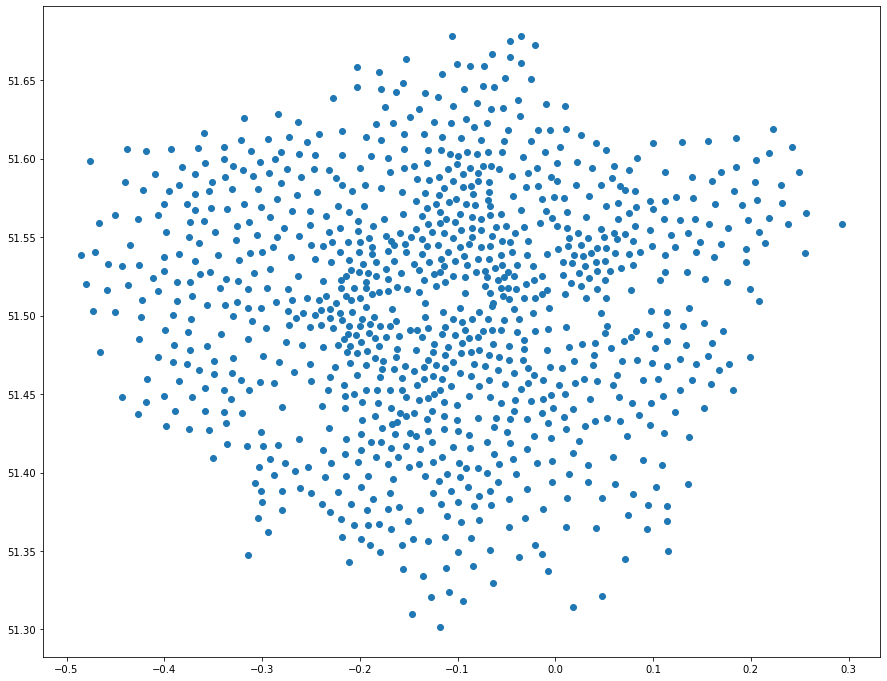

In [149]:
df_json.centroid.plot(figsize=(15,15))

In [150]:
df_json['longitude'] = df_json.centroid.x
df_json['latitude'] = df_json.centroid.y

df_json['longitude_rad'] = [radians(_) for _ in df_json['longitude']]
df_json['latitude_rad'] = [radians(_) for _ in df_json['latitude']]

df_json.drop(['geoeast', 'geonorth', 'popeast', 'popnorth', 'area_km2'], axis=1, inplace=True)
df_json

C:\Users\aliyu\AppData\Local\Temp/ipykernel_3944/4191860136.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_json['longitude'] = df_json.centroid.x
C:\Users\aliyu\AppData\Local\Temp/ipykernel_3944/4191860136.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_json['latitude'] = df_json.centroid.y


,MOVEMENT_ID,geometry,longitude,latitude,longitude_rad,latitude_rad
0,0,"MULTIPOLYGON (((-0.47794 51.55485, -0.47665 51...",-0.470593,51.540762,-0.008213,0.899556
1,1,"MULTIPOLYGON (((0.05255 51.56171, 0.05310 51.5...",0.046567,51.555122,0.000813,0.899807
2,2,"MULTIPOLYGON (((0.01001 51.52181, 0.01003 51.5...",0.010071,51.513538,0.000176,0.899081
3,3,"MULTIPOLYGON (((0.05392 51.51611, 0.05174 51.5...",0.052078,51.511347,0.000909,0.899043
4,4,"MULTIPOLYGON (((0.03241 51.51704, 0.03179 51.5...",0.031180,51.511230,0.000544,0.899041
...,...,...,...,...,...,...
978,978,"MULTIPOLYGON (((-0.17019 51.51994, -0.16019 51...",-0.170714,51.515923,-0.002980,0.899122
979,979,"MULTIPOLYGON (((-0.17867 51.52008, -0.17898 51...",-0.179866,51.514957,-0.003139,0.899106
980,980,"MULTIPOLYGON (((-0.12279 51.49453, -0.12305 51...",-0.129992,51.491930,-0.002269,0.898704
981,981,"MULTIPOLYGON (((-0.14126 51.49455, -0.14080 51...",-0.141541,51.490604,-0.002470,0.898681


In [151]:
df_train = df_train.join(df_json, on='sourceid')
df_train.drop(['MOVEMENT_ID', 'geometry'], axis=1, inplace=True)
df_train.rename(columns={'longitude_rad': 'src_longitude_rad', 'latitude_rad':'src_latitude_rad', 'latitude':'src_latitude','longitude':'src_longitude'}, inplace=True)
df_train

,sourceid,dstid,dow,mean_travel_time,src_area,dst_area,geo_distance,pop_distance,src_longitude,src_latitude,src_longitude_rad,src_latitude_rad
0,10,241,3,2334.43,0.790802,0.584104,14114.137204,14141.759155,0.051341,51.522387,0.000896,0.899235
1,10,612,5,1529.83,0.790802,6.279430,13665.746851,12486.204868,0.051341,51.522387,0.000896,0.899235
2,10,905,4,1390.04,0.790802,0.662274,8249.044187,8333.425766,0.051341,51.522387,0.000896,0.899235
3,10,407,7,157.91,0.790802,0.796626,2258.856791,2371.941188,0.051341,51.522387,0.000896,0.899235
4,10,603,4,1781.67,0.790802,1.282990,17972.040340,18017.793983,0.051341,51.522387,0.000896,0.899235
...,...,...,...,...,...,...,...,...,...,...,...,...
9825,657,207,6,1742.70,2.388420,0.431376,14838.312101,14758.276492,-0.425853,51.532336,-0.007433,0.899409
9826,657,359,2,2693.21,2.388420,1.292420,19944.834369,19834.023142,-0.425853,51.532336,-0.007433,0.899409
9827,657,656,7,298.18,2.388420,2.130680,2206.109698,2155.409242,-0.425853,51.532336,-0.007433,0.899409
9828,657,540,7,312.27,2.388420,2.057230,1860.069891,2020.300225,-0.425853,51.532336,-0.007433,0.899409


In [152]:
df_train = df_train.join(df_json, on='dstid')
df_train.drop(['MOVEMENT_ID', 'geometry'], axis=1, inplace=True)
df_train.rename(columns={'longitude_rad': 'dst_longitude_rad', 'latitude_rad':'dst_latitude_rad', 'latitude':'dst_latitude', 'longitude':'dst_longitude'}, inplace=True)
df_train

,sourceid,dstid,dow,mean_travel_time,src_area,dst_area,geo_distance,pop_distance,src_longitude,src_latitude,src_longitude_rad,src_latitude_rad,dst_longitude,dst_latitude,dst_longitude_rad,dst_latitude_rad
0,10,241,3,2334.43,0.790802,0.584104,14114.137204,14141.759155,0.051341,51.522387,0.000896,0.899235,-0.118199,51.452418,-0.002063,0.898014
1,10,612,5,1529.83,0.790802,6.279430,13665.746851,12486.204868,0.051341,51.522387,0.000896,0.899235,0.184471,51.612990,0.003220,0.900817
2,10,905,4,1390.04,0.790802,0.662274,8249.044187,8333.425766,0.051341,51.522387,0.000896,0.899235,-0.056014,51.490606,-0.000978,0.898681
3,10,407,7,157.91,0.790802,0.796626,2258.856791,2371.941188,0.051341,51.522387,0.000896,0.899235,0.079911,51.532079,0.001395,0.899404
4,10,603,4,1781.67,0.790802,1.282990,17972.040340,18017.793983,0.051341,51.522387,0.000896,0.899235,-0.087059,51.659039,-0.001519,0.901620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9825,657,207,6,1742.70,2.388420,0.431376,14838.312101,14758.276492,-0.425853,51.532336,-0.007433,0.899409,-0.214504,51.512130,-0.003744,0.899056
9826,657,359,2,2693.21,2.388420,1.292420,19944.834369,19834.023142,-0.425853,51.532336,-0.007433,0.899409,-0.139748,51.515227,-0.002439,0.899110
9827,657,656,7,298.18,2.388420,2.130680,2206.109698,2155.409242,-0.425853,51.532336,-0.007433,0.899409,-0.457668,51.532552,-0.007988,0.899413
9828,657,540,7,312.27,2.388420,2.057230,1860.069891,2020.300225,-0.425853,51.532336,-0.007433,0.899409,-0.400300,51.537351,-0.006987,0.899496


In [153]:


def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # Radius of earth in miles. Use 6371 for kilometers
    return c * r

distances = []
for i in range(9830):
    distance = haversine(df_train['src_longitude_rad'][i], df_train['src_latitude_rad'][i], df_train['dst_longitude_rad'][i], df_train['dst_latitude_rad'][i])
    distances.append(distance)

df_train['haversine_distances'] = np.array(distances)
df_train['geo_distance'] /= 1000
df_train['pop_distance'] /= 1000

df_train

,sourceid,dstid,dow,mean_travel_time,src_area,dst_area,geo_distance,pop_distance,src_longitude,src_latitude,src_longitude_rad,src_latitude_rad,dst_longitude,dst_latitude,dst_longitude_rad,dst_latitude_rad,haversine_distances
0,10,241,3,2334.43,0.790802,0.584104,14.114137,14.141759,0.051341,51.522387,0.000896,0.899235,-0.118199,51.452418,-0.002063,0.898014,14.083140
1,10,612,5,1529.83,0.790802,6.279430,13.665747,12.486205,0.051341,51.522387,0.000896,0.899235,0.184471,51.612990,0.003220,0.900817,13.644253
2,10,905,4,1390.04,0.790802,0.662274,8.249044,8.333426,0.051341,51.522387,0.000896,0.899235,-0.056014,51.490606,-0.000978,0.898681,8.227685
3,10,407,7,157.91,0.790802,0.796626,2.258857,2.371941,0.051341,51.522387,0.000896,0.899235,0.079911,51.532079,0.001395,0.899404,2.251140
4,10,603,4,1781.67,0.790802,1.282990,17.972040,18.017794,0.051341,51.522387,0.000896,0.899235,-0.087059,51.659039,-0.001519,0.901620,17.952686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9825,657,207,6,1742.70,2.388420,0.431376,14.838312,14.758276,-0.425853,51.532336,-0.007433,0.899409,-0.214504,51.512130,-0.003744,0.899056,14.794136
9826,657,359,2,2693.21,2.388420,1.292420,19.944834,19.834023,-0.425853,51.532336,-0.007433,0.899409,-0.139748,51.515227,-0.002439,0.899110,19.885227
9827,657,656,7,298.18,2.388420,2.130680,2.206110,2.155409,-0.425853,51.532336,-0.007433,0.899409,-0.457668,51.532552,-0.007988,0.899413,2.200808
9828,657,540,7,312.27,2.388420,2.057230,1.860070,2.020300,-0.425853,51.532336,-0.007433,0.899409,-0.400300,51.537351,-0.006987,0.899496,1.853358


In [154]:
# df_train.to_csv('road_distances.csv')

### Road/Route Distance

The code below shows how to get distance between source and destination id using OSMR api. When using this API we can make 1000 request per session. For 9830 rows it will take some time that is why I only show code in comment.

In [155]:
# Calculating distance between two points using OSMR API

# df_distances = pd.read_csv('road_distances.csv')
# df_json = gpd.read_file('london.json')
# df_json.centroid.x
# df_json.centroid.y
# df_distances.drop('Unnamed: 0', axis=1, inplace=True)
# route_distances = []
# for i in range(0,9830):
#     r = requests.get(f"http://router.project-osrm.org/route/v1/car/{df_distances['src_longitude'][i]},{df_distances['src_latitude'][i]};{df_distances['dst_longitude'][i]},{df_distances['dst_latitude'][i]}?overview=false""")
#
#     routes = json.loads(r.content)
#     route_1 = routes.get('routes')[0]
#     route_distances.append(route_1['distance'])
#     print(route_distances[i])
#
# dist = np.array(route_distances)
# distance_df = pd.DataFrame(dist)
# distance_df.to_csv('distances.csv')

In [156]:
df_distances=pd.read_csv('distances.csv')

In [157]:
df_distances

,Unnamed: 0,0
0,0,18708.0
1,1,17164.9
2,2,11496.9
3,3,3070.1
4,4,25084.6
...,...,...
9825,9825,18512.9
9826,9826,22729.5
9827,9827,5354.1
9828,9828,2366.1


In [158]:
df_distances.drop('Unnamed: 0', axis=1, inplace=True)

In [159]:
df_train['route_distances']=df_distances/1000

In [160]:
df_train

,sourceid,dstid,dow,mean_travel_time,src_area,dst_area,geo_distance,pop_distance,src_longitude,src_latitude,src_longitude_rad,src_latitude_rad,dst_longitude,dst_latitude,dst_longitude_rad,dst_latitude_rad,haversine_distances,route_distances
0,10,241,3,2334.43,0.790802,0.584104,14.114137,14.141759,0.051341,51.522387,0.000896,0.899235,-0.118199,51.452418,-0.002063,0.898014,14.083140,18.7080
1,10,612,5,1529.83,0.790802,6.279430,13.665747,12.486205,0.051341,51.522387,0.000896,0.899235,0.184471,51.612990,0.003220,0.900817,13.644253,17.1649
2,10,905,4,1390.04,0.790802,0.662274,8.249044,8.333426,0.051341,51.522387,0.000896,0.899235,-0.056014,51.490606,-0.000978,0.898681,8.227685,11.4969
3,10,407,7,157.91,0.790802,0.796626,2.258857,2.371941,0.051341,51.522387,0.000896,0.899235,0.079911,51.532079,0.001395,0.899404,2.251140,3.0701
4,10,603,4,1781.67,0.790802,1.282990,17.972040,18.017794,0.051341,51.522387,0.000896,0.899235,-0.087059,51.659039,-0.001519,0.901620,17.952686,25.0846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9825,657,207,6,1742.70,2.388420,0.431376,14.838312,14.758276,-0.425853,51.532336,-0.007433,0.899409,-0.214504,51.512130,-0.003744,0.899056,14.794136,18.5129
9826,657,359,2,2693.21,2.388420,1.292420,19.944834,19.834023,-0.425853,51.532336,-0.007433,0.899409,-0.139748,51.515227,-0.002439,0.899110,19.885227,22.7295
9827,657,656,7,298.18,2.388420,2.130680,2.206110,2.155409,-0.425853,51.532336,-0.007433,0.899409,-0.457668,51.532552,-0.007988,0.899413,2.200808,5.3541
9828,657,540,7,312.27,2.388420,2.057230,1.860070,2.020300,-0.425853,51.532336,-0.007433,0.899409,-0.400300,51.537351,-0.006987,0.899496,1.853358,2.3661


This dataset above will be our final dataset that we will work on it.

### Encoding 'dow' column
As it is known day of week column named as 'dow' is categorical but in our dataset it looks like numerical. Because of that we will encode this column.

## Train test split

In [161]:
df_train[['dow']]=df_train[['dow']].astype(str)

In [162]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9830 entries, 0 to 9829
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sourceid             9830 non-null   int64  
 1   dstid                9830 non-null   int64  
 2   dow                  9830 non-null   object 
 3   mean_travel_time     9830 non-null   float64
 4   src_area             9830 non-null   float64
 5   dst_area             9830 non-null   float64
 6   geo_distance         9830 non-null   float64
 7   pop_distance         9830 non-null   float64
 8   src_longitude        9830 non-null   float64
 9   src_latitude         9830 non-null   float64
 10  src_longitude_rad    9830 non-null   float64
 11  src_latitude_rad     9830 non-null   float64
 12  dst_longitude        9830 non-null   float64
 13  dst_latitude         9830 non-null   float64
 14  dst_longitude_rad    9830 non-null   float64
 15  dst_latitude_rad     9830 non-null   f

In [163]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(df_train[['dow']]).toarray())
# merge with main df bridge_df on key values
df_train = df_train.join(enc_df)

In [168]:
df_train.rename(columns={0: 'Monday', 1:'Tuesday', 2:'Wednesday',3:'Thursday', 4:'Friday', 5: 'Saturday', 6: 'Sunday'}, inplace=True)

In [169]:
df_train.columns

Index(['sourceid', 'dstid', 'dow', 'mean_travel_time', 'src_area', 'dst_area',
       'geo_distance', 'pop_distance', 'src_longitude', 'src_latitude',
       'src_longitude_rad', 'src_latitude_rad', 'dst_longitude',
       'dst_latitude', 'dst_longitude_rad', 'dst_latitude_rad',
       'haversine_distances', 'route_distances', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
      dtype='object')

In [170]:
df_train

,sourceid,dstid,dow,mean_travel_time,src_area,dst_area,geo_distance,pop_distance,src_longitude,src_latitude,...,dst_latitude_rad,haversine_distances,route_distances,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,10,241,3,2334.43,0.790802,0.584104,14.114137,14.141759,0.051341,51.522387,...,0.898014,14.083140,18.7080,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,10,612,5,1529.83,0.790802,6.279430,13.665747,12.486205,0.051341,51.522387,...,0.900817,13.644253,17.1649,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,10,905,4,1390.04,0.790802,0.662274,8.249044,8.333426,0.051341,51.522387,...,0.898681,8.227685,11.4969,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,10,407,7,157.91,0.790802,0.796626,2.258857,2.371941,0.051341,51.522387,...,0.899404,2.251140,3.0701,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,10,603,4,1781.67,0.790802,1.282990,17.972040,18.017794,0.051341,51.522387,...,0.901620,17.952686,25.0846,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9825,657,207,6,1742.70,2.388420,0.431376,14.838312,14.758276,-0.425853,51.532336,...,0.899056,14.794136,18.5129,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9826,657,359,2,2693.21,2.388420,1.292420,19.944834,19.834023,-0.425853,51.532336,...,0.899110,19.885227,22.7295,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9827,657,656,7,298.18,2.388420,2.130680,2.206110,2.155409,-0.425853,51.532336,...,0.899413,2.200808,5.3541,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9828,657,540,7,312.27,2.388420,2.057230,1.860070,2.020300,-0.425853,51.532336,...,0.899496,1.853358,2.3661,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Selecting dependent and independent columns

In [171]:
X=df_train[['src_area','dst_area', 'geo_distance', 'pop_distance', 'haversine_distances', 'route_distances', 'Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday', 'Saturday', 'Sunday']]
y=df_train['mean_travel_time']

## Model

We build function for model building which will take X and y as arguments and will show the RMSE values for each regression model.

In [185]:
def model_rmse_checker(X, y):
    x_train, x_test, y_train, y_test=train_test_split(X, y, random_state=123, test_size=0.3)
    xgr=XGBRegressor()
    cbr=CatBoostRegressor(silent=True)
    abr=AdaBoostRegressor()
    gbr=GradientBoostingRegressor()
    svmr=SVR()
    lr=LinearRegression()
    lassor=Lasso()
    xgr.fit(x_train, y_train)
    y_pred=xgr.predict(x_test)
    print(f'RMSE for XGB Regressor {mean_squared_error(y_test, y_pred, squared=False)}')

    cbr.fit(x_train, y_train)
    y_pred=cbr.predict(x_test)
    print(f'RMSE for CatBoost Regressor {mean_squared_error(y_test, y_pred, squared=False)}')

    abr.fit(x_train, y_train)
    y_pred=abr.predict(x_test)
    print(f'RMSE for AdaBoost Regressor {mean_squared_error(y_test, y_pred, squared=False)}')

    gbr.fit(x_train, y_train)
    y_pred=gbr.predict(x_test)
    print(f'RMSE for Gradient Boost Regressor {mean_squared_error(y_test, y_pred, squared=False)}')

    svmr.fit(x_train, y_train)
    y_pred=svmr.predict(x_test)
    print(f'RMSE for Support Vector Machine Regressor {mean_squared_error(y_test, y_pred, squared=False)}')

    lr.fit(x_train, y_train)
    y_pred=lr.predict(x_test)
    print(f'RMSE for Linear Regressor {mean_squared_error(y_test, y_pred, squared=False)}')

    lassor.fit(x_train, y_train)
    y_pred=lassor.predict(x_test)
    print(f'RMSE for Lasso Regressor {mean_squared_error(y_test, y_pred, squared=False)}')

In [186]:
model_rmse_checker(X,y)

RMSE for XGB Regressor 346.7056060639983
RMSE for CatBoost Regressor 345.43123061866646
RMSE for AdaBoost Regressor 394.68364770048487
RMSE for Gradient Boost Regressor 354.9192764012848
RMSE for Support Vector Machine Regressor 496.64611354895897
RMSE for Linear Regressor 411.9368516044699
RMSE for Lasso Regressor 412.25921790596686


C:\Users\aliyu\anaconda3\envs\ali_root\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 429996.88886499405, tolerance: 379947.0931418353
  model = cd_fast.enet_coordinate_descent(
